In [2]:
import warnings
from copy import deepcopy

import astropy.units as u
import numpy as np
import sunpy.map
from scipy.ndimage import shift
from skimage.feature import match_template
from sunpy.map.mapbase import GenericMap
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.util.exceptions import SunpyUserWarning


/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [3]:
def _default_fmap_function(data):
    """
    This function ensures that the data are floats.

    It is the default data manipulation function for the coalignment
    method.
    """
    return np.float64(data)

def _check_for_nonfinite_entries(layer_image, template_image):
    """
    Issue a warning if there is any nonfinite entry in the layer or template
    images.

    Parameters
    ----------
    layer_image : `numpy.ndarray`
        A two-dimensional `numpy.ndarray`.
    template_image : `numpy.ndarray`
        A two-dimensional `numpy.ndarray`.
    """
    if not np.all(np.isfinite(layer_image)):
        warnings.warn(
            "The layer image has nonfinite entries. "
            "This could cause errors when calculating shift between two "
            "images. Please make sure there are no infinity or "
            "Not a Number values. For instance, replacing them with a "
            "local mean.",
            SunpyUserWarning,
            stacklevel=3,
        )

    if not np.all(np.isfinite(template_image)):
        warnings.warn(
            "The template image has nonfinite entries. "
            "This could cause errors when calculating shift between two "
            "images. Please make sure there are no infinity or "
            "Not a Number values. For instance, replacing them with a "
            "local mean.",
            SunpyUserWarning,
            stacklevel=3,
        )

def _get_correlation_shifts(array):
    """
    Estimate the location of the maximum of a fit to the input array. The
    estimation in the "x" and "y" directions are done separately. The location
    estimates can be used to implement subpixel shifts between two different
    images.

    Parameters
    ----------
    array : `numpy.ndarray`
        An array with at least one dimension that has three elements. The
        input array is at most a 3x3 array of correlation values calculated
        by matching a template to an image.

    Returns
    -------
    `~astropy.units.Quantity`
        The ``(y, x)`` location of the peak of a parabolic fit, in image pixels.
    """
    # Check input shape
    ny = array.shape[0]
    nx = array.shape[1]
    if nx > 3 or ny > 3:
        msg = "Input array dimension should not be greater than 3 in any dimension."
        raise ValueError(msg)

    # Find where the maximum of the input array is
    ij = np.unravel_index(np.argmax(array), array.shape)
    x_max_location, y_max_location = ij[::-1]

    # Estimate the location of the parabolic peak if there is enough data.
    # Otherwise, just return the location of the maximum in a particular
    # direction.
    y_location = _parabolic_turning_point(array[:, x_max_location]) if ny == 3 else 1.0 * y_max_location

    x_location = _parabolic_turning_point(array[y_max_location, :]) if nx == 3 else 1.0 * x_max_location

    return y_location * u.pix, x_location * u.pix


def _parabolic_turning_point(y):
    """
    Find the location of the turning point for a parabola ``y(x) = ax^2 + bx +
    c``, given input values ``y(-1), y(0), y(1)``. The maximum is located at
    ``x0 = -b / 2a``. Assumes that the input array represents an equally spaced
    sampling at the locations ``y(-1), y(0) and y(1)``.

    Parameters
    ----------
    y : `numpy.ndarray`
        A one dimensional numpy array of shape "3" with entries that sample the
        parabola at "-1", "0", and "1".

    Returns
    -------
    `float`
        A float, the location of the parabola maximum.
    """
    numerator = -0.5 * y.dot([-1, 0, 1])
    denominator = y.dot([1, -2, 1])
    return numerator / denominator

@u.quantity_input
def _calculate_clipping(y: u.pix, x: u.pix):
    """
    Return the upper and lower clipping values for the "y" and "x" directions.

    Parameters
    ----------
    y : `astropy.units.Quantity`
        An array of pixel shifts in the y-direction for an image.
    x : `astropy.units.Quantity`
        An array of pixel shifts in the x-direction for an image.

    Returns
    -------
    `tuple`
        The tuple is of the form ``([y0, y1], [x0, x1])``.
        The number of (integer) pixels that need to be clipped off at each
        edge in an image. The first element in the tuple is a list that gives
        the number of pixels to clip in the y-direction. The first element in
        that list is the number of rows to clip at the lower edge of the image
        in y. The clipped image has "clipping[0][0]" rows removed from its
        lower edge when compared to the original image. The second element in
        that list is the number of rows to clip at the upper edge of the image
        in y. The clipped image has "clipping[0][1]" rows removed from its
        upper edge when compared to the original image. The second element in
        the "clipping" tuple applies similarly to the x-direction (image
        columns). The parameters ``y0, y1, x0, x1`` have the type
        `~astropy.units.Quantity`.
    """
    return (
        [_lower_clip(y.value), _upper_clip(y.value)] * u.pix,
        [_lower_clip(x.value), _upper_clip(x.value)] * u.pix,
    )

def _upper_clip(z):
    """
    Find smallest integer bigger than all the positive entries in the input
    array.
    """
    zcond = z >= 0
    return int(np.max(np.ceil(z[zcond]))) if np.any(zcond) else 0


def _lower_clip(z):
    """
    Find smallest positive integer bigger than the absolute values of the
    negative entries in the input array.
    """
    zcond = z <= 0
    return int(np.max(np.ceil(-z[zcond]))) if np.any(zcond) else 0

@u.quantity_input
def _clip_edges(data, yclips: u.pix, xclips: u.pix):
    """
    Clips off the "y" and "x" edges of a 2D array according to a list of pixel
    values. This function is useful for removing data at the edge of 2d images
    that may be affected by shifts from solar de- rotation and layer co-
    registration, leaving an image unaffected by edge effects.

    Parameters
    ----------
    data : `numpy.ndarray`
        A numpy array of shape ``(ny, nx)``.
    yclips : `astropy.units.Quantity`
        The amount to clip in the y-direction of the data. Has units of
        pixels, and values should be whole non-negative numbers.
    xclips : `astropy.units.Quantity`
        The amount to clip in the x-direction of the data. Has units of
        pixels, and values should be whole non-negative numbers.

    Returns
    -------
    `numpy.ndarray`
        A 2D image with edges clipped off according to ``yclips`` and ``xclips``
        arrays.
    """
    ny = data.shape[0]
    nx = data.shape[1]
    # The purpose of the int below is to ensure integer type since by default
    # astropy quantities are converted to floats.
    return data[int(yclips[0].value) : ny - int(yclips[1].value), int(xclips[0].value) : nx - int(xclips[1].value)]



def _find_best_match_location(corr):
    """
    Calculate an estimate of the location of the peak of the correlation result
    in image pixels.

    Parameters
    ----------
    corr : `numpy.ndarray`
        A 2D correlation array.

    Returns
    -------
    `~astropy.units.Quantity`
        The shift amounts ``(y, x)`` in image pixels. Subpixel values are
        possible.
    """
    # Get the index of the maximum in the correlation function
    ij = np.unravel_index(np.argmax(corr), corr.shape)
    cor_max_x, cor_max_y = ij[::-1]

    # Get the correlation function around the maximum
    array_maximum = corr[
        np.max([0, cor_max_y - 1]) : np.min([cor_max_y + 2, corr.shape[0] - 1]),
        np.max([0, cor_max_x - 1]) : np.min([cor_max_x + 2, corr.shape[1] - 1]),
    ]
    y_shift_maximum, x_shift_maximum = _get_correlation_shifts(array_maximum)

    # Get shift relative to correlation array
    y_shift_correlation_array = y_shift_maximum + cor_max_y * u.pix
    x_shift_correlation_array = x_shift_maximum + cor_max_x * u.pix

    return y_shift_correlation_array, x_shift_correlation_array




def _calculate_shift(this_layer, template):
    """
    Calculates the pixel shift required to put the template in the "best"
    position on a layer.

    Parameters
    ----------
    this_layer : `numpy.ndarray`
        A numpy array of size ``(ny, nx)``, where the first two dimensions are
        spatial dimensions.
    template : `numpy.ndarray`
        A numpy array of size ``(N, M)`` where ``N < ny`` and ``M < nx``.

    Returns
    -------
    `tuple`
        Pixel shifts ``(yshift, xshift)`` relative to the offset of the template
        to the input array.
    """
    # Warn user if any NANs, Infs, etc are present in the layer or the template
    _check_for_nonfinite_entries(this_layer, template)
    # Calculate the correlation array matching the template to this layer
    corr = match_template(this_layer, template)
    # Calculate the y and x shifts in pixels
    return _find_best_match_location(corr)


In [4]:
@u.quantity_input
def apply_shift_to_sequence(mapsequence, shifts):
    # New mapsequence will be constructed from this list
    new_mc = []
    xshift = -shifts["x"]
    yshift = -shifts["y"] 
    # Calculate the clipping (Assumed True by default)
    yclips, xclips = _calculate_clipping(-yshift, -xshift)

    # Shift the data and construct the mapsequence
    for i, m in enumerate(mapsequence):
        shifted_data = shift(deepcopy(m.data), [yshift[i].value, xshift[i].value])
        new_meta = deepcopy(m.meta)
        # Clip if required.  Use the submap function to return the appropriate
        # portion of the data.
        shifted_data = _clip_edges(shifted_data, yclips, xclips)
        new_meta["naxis1"] = shifted_data.shape[1]
        new_meta["naxis2"] = shifted_data.shape[0]
        # Add one to go from zero-based to one-based indexing
        new_meta["crpix1"] = m.reference_pixel.x.value + 1 + xshift[i].value - xshift[0].value
        new_meta["crpix2"] = m.reference_pixel.y.value + 1 + yshift[i].value - yshift[0].value

        new_map = sunpy.map.Map(shifted_data, new_meta)

        # Append to the list
        new_mc.append(new_map)

    return sunpy.map.Map(new_mc, sequence=True)

def calculate_match_template_shift(mapsequence, template, func, layer_index):
    # Logic to calculate the arcsecond shift to match the template
    nt = len(mapsequence.maps)

    # Calculate a template.  If no template is passed then define one
    # from the index layer.
    if template is None:
        # Size of the data
        ny = mapsequence.maps[layer_index].data.shape[0]
        nx = mapsequence.maps[layer_index].data.shape[1]
        tplate = mapsequence.maps[layer_index].data[int(ny / 4) : int(3 * ny / 4), int(nx / 4) : int(3 * nx / 4)]
    elif isinstance(template, GenericMap):
        tplate = template.data
    elif isinstance(template, np.ndarray):
        tplate = template
    else:
        msg = "Invalid template."
        raise ValueError(msg)

    # Apply the function to the template
    tplate = func(tplate)

    # Storage for the pixel shift
    xshift_keep = np.zeros(nt) * u.pix
    yshift_keep = np.zeros_like(xshift_keep)

    # Storage for the arcsecond shift
    xshift_arcseconds = np.zeros(nt) * u.arcsec
    yshift_arcseconds = np.zeros_like(xshift_arcseconds)

    # Match the template and calculate shifts
    for i, m in enumerate(mapsequence.maps):
        # Get the next 2-d data array
        this_layer = func(m.data)

        # Calculate the y and x shifts in pixels
        yshift, xshift = _calculate_shift(this_layer, tplate)

        # Keep shifts in pixels
        yshift_keep[i] = yshift
        xshift_keep[i] = xshift

    # Calculate shifts relative to the template layer
    yshift_keep = yshift_keep - yshift_keep[layer_index]
    xshift_keep = xshift_keep - xshift_keep[layer_index]

    for i, m in enumerate(mapsequence.maps):
        # Calculate the shifts required in physical units, which are
        # presumed to be arcseconds.
        xshift_arcseconds[i] = xshift_keep[i] * m.scale[0]
        yshift_arcseconds[i] = yshift_keep[i] * m.scale[1]

    return {"x": xshift_arcseconds, "y": yshift_arcseconds}

def calculate_solar_rotation_shift(mapsequence, layer_index):
    # Logic to calculate the arcsecond shift to compensate for solar rotation
    nt = len(mapsequence.maps)
    xshift_arcseconds = np.zeros(nt) * u.arcsec
    yshift_arcseconds = np.zeros_like(xshift_arcseconds)
    rotate_to_this_layer = mapsequence.maps[layer_index]

    for i, m in enumerate(mapsequence):
        # The shift of the reference layer is always zero by definition.
        if i == layer_index:
            continue

        # Calculate the rotation of the center of the map 'm' at its
        # observation time to the observation time of the reference layer
        # indicated by "layer_index".
        new_coordinate = solar_rotate_coordinate(m.center, observer=rotate_to_this_layer.observer_coordinate, **kwargs)

        xshift_arcseconds[i] = new_coordinate.Tx - rotate_to_this_layer.center.Tx
        yshift_arcseconds[i] = new_coordinate.Ty - rotate_to_this_layer.center.Ty

    return {"x": xshift_arcseconds, "y": yshift_arcseconds}
    


## Sub Functions

In [13]:
def match_by_template(mapsequence, template, layer_index, shift, func, apply_shift):
    # Number of maps
    nt = len(mapsequence.maps)

    # Storage for the pixel shifts and the shifts in arcseconds
    xshift_keep = np.zeros(nt) * u.pix
    yshift_keep = np.zeros_like(xshift_keep)
    
    if apply_shift and shift:
        # Apply the shift and return the new mapsequence
        if (shift["x"].unit == u.arcsec):## If the shifts provided are in arcsec convert to pixels and then apply.
            for i, m in enumerate(mc):
                xshift_keep[i] = shift["x"][i] / m.scale[0]
                yshift_keep[i] = shift["y"][i] / m.scale[1]
            pixel_shifts = {"x": xshift_keep, "y": yshift_keep}
        new_mapsequence = apply_shift_to_sequence(mapsequence, pixel_shifts)
        return new_mapsequence
    # Calculate the arcsecond shift 
    arcsecond_shift = calculate_match_template_shift(mapsequence, template=template, func=func, layer_index=layer_index)
    xshift_arcseconds = arcsecond_shift["x"]
    yshift_arcseconds = arcsecond_shift["y"]

    # If only the apply_shift is True, then apply the arcsecond shifts and then return the new mapseq
    if apply_shift:
        # Calculate the pixel shifts
        for i, m in enumerate(mapsequence):
            xshift_keep[i] = xshift_arcseconds[i] / m.scale[0]
            yshift_keep[i] = yshift_arcseconds[i] / m.scale[1]
        pixel_shifts = {"x": xshift_keep, "y": yshift_keep}
        new_mapsequence = apply_shift_to_sequence(mapsequence, pixel_shifts)
        return new_mapsequence
    else:
        # Return the arcsecond shift to match the template
        return arcsecond_shift


def solar_rotate(mapsequence, template, layer_index, shift, func, apply_shift):
    # Implementation for solar_rotate method
    if apply_shift and shift:
        # Apply the shift and return the new mapsequence
        new_mapsequence = apply_shift_to_sequence(mapsequence, shift)
        return new_mapsequence
    # Calculate the arcsecond shift 
    arcsecond_shift = calculate_solar_rotation_shift(mapsequence, layer_index=0)
    # If only the apply_shift is True, then apply the arcsecond shifts and then return the new mapseq
    elif apply_shift:
        new_mapsequence = apply_shift_to_sequence(mapsequence, arcsecond_shift)
        return new_mapsequence
    else:
        # Return the arcsecond shift to compensate for solar rotation
        return arcsecond_shift


## Main Wrapper

In [6]:
def mapsequence_coalign(
    mapsequence,
    template=None,
    layer_index=0,
    shift=None,
    func=_default_fmap_function,
    apply_shift=True,
    method='match_template',
    **kwargs
):
    if method == 'match_template':
        return match_by_template(
            mapsequence=mapsequence, template=template, layer_index=layer_index, shift=shift, func=func, apply_shift=apply_shift)
    elif method == 'solar_rotate':
        return solar_rotate(
            mapsequence, template, layer_index, shift, func, apply_shift
        )
    else:
        raise ValueError("Unsupported method. Choose either 'match_template' or 'solar_rotate'")


In [7]:
import matplotlib.pyplot as plt
import sunpy.data.sample
from sunpy.map import Map

Files Downloaded: 100%|██████████| 1/1 [00:00<00:00,  1.77file/s]


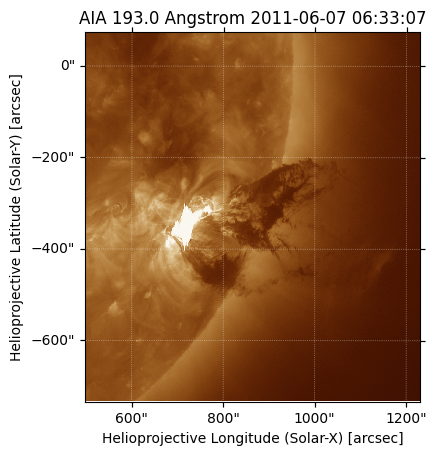

In [8]:
mc = Map(
    [
        sunpy.data.sample.AIA_193_CUTOUT01_IMAGE,
        sunpy.data.sample.AIA_193_CUTOUT02_IMAGE,
        sunpy.data.sample.AIA_193_CUTOUT03_IMAGE,
        sunpy.data.sample.AIA_193_CUTOUT04_IMAGE,
        sunpy.data.sample.AIA_193_CUTOUT05_IMAGE,
    ],
    sequence=True,
)
plt.figure()
anim = mc.plot()

In [9]:
coaligned = mapsequence_coalign(mc) ## By default match by template

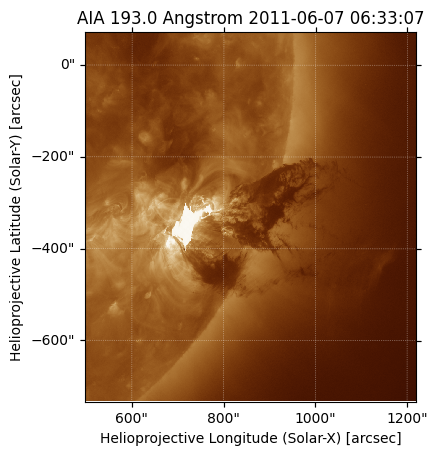

In [10]:
plt.figure()
anim_coalign = coaligned.plot()

In [11]:
shifts = mapsequence_coalign(mc, apply_shift=False) ## Returns the shifts in arcseconds
shifts

{'x': <Quantity [0.        , 2.05246166, 2.64773282, 4.31195047, 9.30375921] arcsec>,
 'y': <Quantity [ 0.        ,  0.99846895, -0.70210477, -0.97778854,  1.04613063] arcsec>}

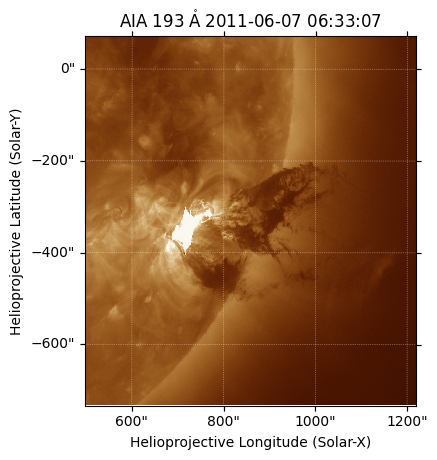

In [14]:
coaligned_shifts = mapsequence_coalign(mc, shift=shifts)

plt.figure()
anim_coaligned_shifts = coaligned_shifts.plot()

plt.show()